# Medical Images Segmentation


Import Libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
from math import ceil
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, Concatenate, BatchNormalization, Dropout, Conv2DTranspose, concatenate, Add, Flatten, Dense


from tensorflow import keras
from keras import models

from datetime import datetime



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Fri Aug 18 15:13:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Dataset used

A radiology dataset (<https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database>) that contains chest X-ray scans collected from various hospitals. It contains chest X-ray scans. All the X-ray scans contain a corresponding pixel level annotation of lungs.

### Preprocessing

In [3]:
PATH_TO_PROJECT = 'gdrive/Shareddrives/Segmentation Project/'

In [4]:
normal_df = pd.read_excel(PATH_TO_PROJECT + 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
covid_df = pd.read_excel(PATH_TO_PROJECT + 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
pneumonia_df = pd.read_excel(PATH_TO_PROJECT + 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')
other_df = pd.read_excel(PATH_TO_PROJECT + 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx')

A very basic metadata review shows that all images are 256 by 256, and in PNG format. Therefore, we may drop these features, as well the URL column. We'll replace these features with two new features: **PATH_IMAGE** and **PATH_MASK**.

In [5]:
'''
Function to remove 'FORMAT','SIZE','URL' columns; as well as
to create 'PATH_IMAGE' and 'PATH_MASK' columns, which simply
consist of the path to each sample's image and mask.
We also add the 'CLASS' feature.

Parameters:
    df (DataFrame): Unprocessed dataframe
Returns:
    df (DataFrame): Processed dataframe
'''
def preliminary_preprocessing(df):
    # If being rerun, won't crash runtime. If FORMAT is in df, others will be too.
    if ('FORMAT' in df.columns.tolist()):
        # Drop mentioned features
        df = df.drop(['FORMAT','SIZE','URL'],axis=1)
    # Determine folder name
    dir_name = df['FILE NAME'][0].split('-')[0]
    # Properly format name - all except COVID dir can be formatted by title
    dir_name = dir_name.title() if dir_name.lower() != 'covid' else dir_name.upper()
    # Add class column
    df['CLASS'] = dir_name
    # Add paths and dir name
    dir_path = os.path.join(PATH_TO_PROJECT+'COVID-19_Radiography_Dataset', dir_name, 'images')
    # Store list of all image paths
    path_image = os.listdir(dir_path)
    # Sort paths by number in dir name
    path_image = sorted(path_image, key=lambda x: int(x.lstrip(dir_name+'-').rstrip('.png')))
    # Add full root path to each (sorted) image
    path_image = [os.path.join(dir_path, i) for i in path_image]
    # Mask paths are the same as images, bar root folder
    path_mask = [i.replace('images','masks') for i in path_image]
    # Add paths lists to df
    df['PATH_IMAGE'] = path_image
    df['PATH_MASK'] = path_mask
    # Return updated df
    return df

Apply process

**Note:** Calculations are commented out, as reading them from csv is faster.


In [ ]:
# # Apply process
# normal_df = preliminary_preprocessing(normal_df)
# covid_df = preliminary_preprocessing(covid_df)
# pneumonia_df = preliminary_preprocessing(pneumonia_df)
# other_df = preliminary_preprocessing(other_df)

DataFrame Sampling, due to computational limitations

In [ ]:
# normal_df = normal_df.sample(frac=0.3, random_state=42)
# covid_df = covid_df.sample(frac=0.3, random_state=42)
# pneumonia_df = pneumonia_df.sample(frac=0.3, random_state=42)
# other_df = other_df.sample(frac=0.3, random_state=42)

Write to File

In [ ]:
# # Write to file for faster recurring runtimes
# normal_df.to_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','normal_df.csv'), index = False)
# covid_df.to_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','covid_df.csv'), index = False)
# pneumonia_df.to_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','pneumonia_df.csv'), index = False)
# other_df.to_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','other_df.csv'), index = False)

Load DataFrames

In [6]:
# Load dataframes
normal_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','normal_df.csv'))
covid_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','covid_df.csv'))
pneumonia_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','pneumonia_df.csv'))
other_df = pd.read_csv(os.path.join(PATH_TO_PROJECT,'Notebooks/path_dataframes','other_df.csv'))

DataFrame Joining
Since this project is not about classification of images, we can combine all of our data so that we can build a more effective segmentation model. However, we will keep track of the class of image, as it may be interesting to note what classes of image performed better/worse regarding the segmentation results. For this reason, we will also be *stratifying* our test-train-val split by the CLASS feature.

In [7]:
combined_df = pd.concat([normal_df, covid_df, pneumonia_df, other_df], axis=0, ignore_index=True)

### Basic Data Visualisation

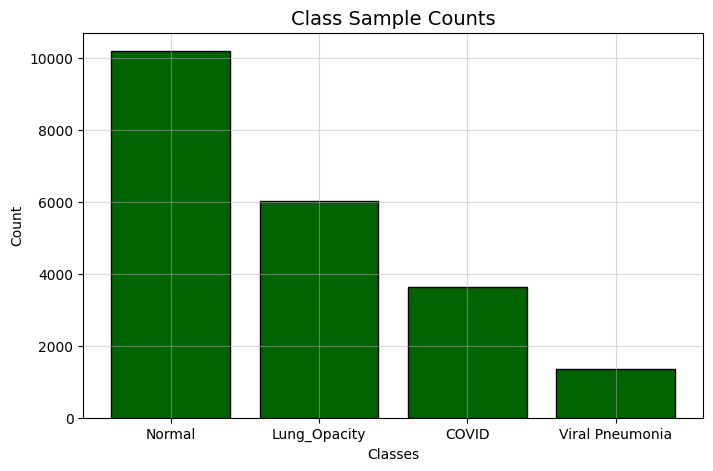

In [ ]:
plt.figure(figsize=(8, 5))
val_counts_classes = combined_df['CLASS'].value_counts()
plt.bar(val_counts_classes.index, val_counts_classes.values, color = 'darkgreen', edgecolor = 'black')
# Title, axes labels
plt.title('Class Sample Counts', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Count')


# Add grid lines
plt.grid(True, alpha=0.5)

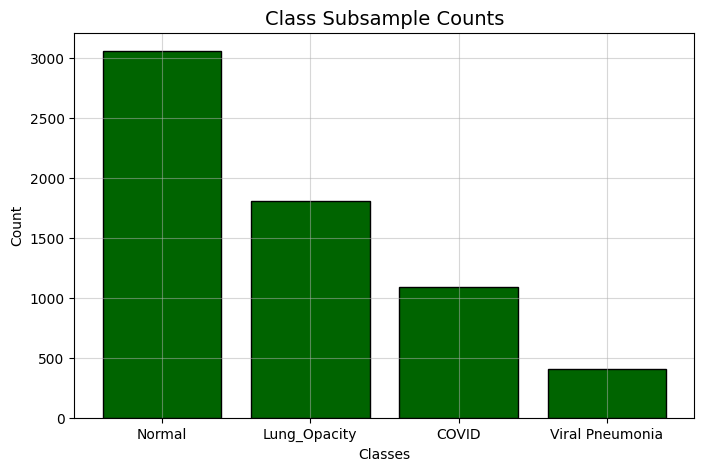

In [ ]:
plt.figure(figsize=(8, 5))
val_counts_classes = combined_df['CLASS'].value_counts()
plt.bar(val_counts_classes.index, val_counts_classes.values, color = 'darkgreen', edgecolor = 'black')
# Title, axes labels
plt.title('Class Subsample Counts', fontsize=14)
plt.xlabel('Classes')
plt.ylabel('Count')


# Add grid lines
plt.grid(True, alpha=0.5)

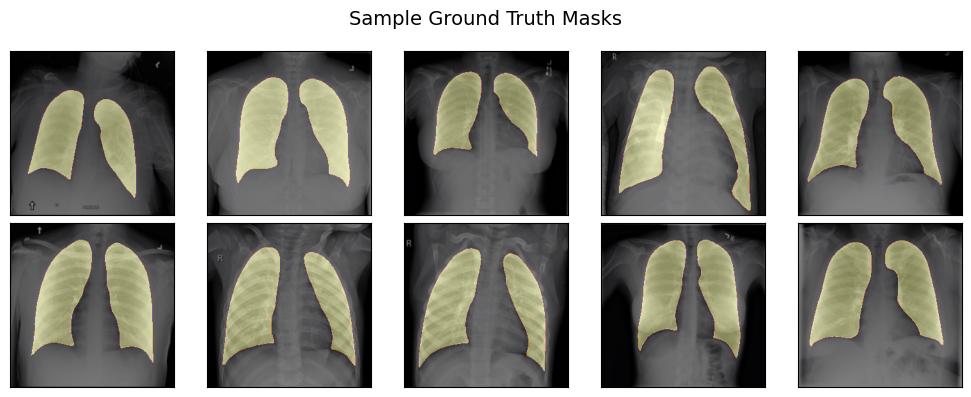

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.suptitle('Sample Ground Truth Masks', fontsize=14)

for i in range(2):
    for j in range(5):
        # Select a random column index
        random_index = np.random.randint(0, combined_df.shape[0]-1)

        # Get the selected column name
        vis_img = plt.imread(combined_df.iloc[random_index]['PATH_IMAGE'])
        vis_mask = plt.imread(combined_df.iloc[random_index]['PATH_MASK'])
        vis_img = cv2.resize(vis_img, (256,256))

        axes[i,j].imshow(vis_img, cmap = 'gray')
        axes[i,j].imshow(vis_mask[:,:,0], cmap = 'inferno', alpha=0.5)

        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.tight_layout()

### Test-Train-Validation Split
The suggested split for this project was 50%-20%-30%, for training, validation, and testing, respectively. This is to reduce training times - to some degree. We will stratify by class.

In [8]:
# First Divide data in half
X_train, X_test, y_train, y_test = train_test_split(combined_df[['PATH_IMAGE', 'CLASS']], combined_df['PATH_MASK'], test_size=0.5, random_state=42, stratify = combined_df['CLASS'].tolist())
# Subsequently, divide test set again
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42, stratify = X_test['CLASS'].tolist())
# View counts/proportions
print(f'Counts:\nTrain: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}')
print(f'Proportions:\nTrain: {len(y_train)/combined_df.shape[0]:.3f}, Val: {len(y_val)/combined_df.shape[0]:.3f}, Test: {len(y_test)/combined_df.shape[0]:.3f}')

Counts:
Train: 3175, Val: 1270, Test: 1906
Proportions:
Train: 0.500, Val: 0.200, Test: 0.300


### Image Loading
In this Subsection we build a function to load our images in the desired format. This function could be expanded to include other preprocessing, or augmentation.

Generator

In [9]:
'''
Function to...

Parameters:
  ...
Returns...
'''
def process_load_generator(X,y,batch_size=32,target_size=256):
  # Transforms and augmentations
  idg = ImageDataGenerator(rescale=1.0/(target_size-1))
  # rotation_range=20,
  # horizontal_flip=True,

  # something
  ig = idg.flow_from_dataframe(
    dataframe=X,
    x_col='PATH_IMAGE',
    y_col=None,  # Set to None if there are no labels
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode=None,  # Set to None since there are no labels
    color_mode='rgb',
    shuffle=False,
    seed=42
  )
  # something
  mg = idg.flow_from_dataframe(
    dataframe=y.to_frame(),
    x_col='PATH_MASK',
    y_col=None,  # Set to None if there are no labels
    target_size=(target_size, target_size),
    batch_size=batch_size,
    class_mode=None,  # Set to None since there are no labels
    color_mode='grayscale',
    shuffle=False,
    seed=42
  )
  # Yield zipped images and masks
  # for (imgs, msks) in zip(ig, mg):
  #   yield imgs, msks
  return zip(ig, mg)

Load generators

In [10]:
batch_size = 32
target_size = 256
train_generator = process_load_generator(X_train, y_train, batch_size, target_size)
val_generator = process_load_generator(X_val, y_val, batch_size, target_size)
test_generator = process_load_generator(X_test, y_test, batch_size, target_size)

Found 3175 validated image filenames.
Found 3175 validated image filenames.
Found 1270 validated image filenames.
Found 1270 validated image filenames.
Found 1906 validated image filenames.
Found 1906 validated image filenames.


### Modelling

**Evaluation Metrics**

**Dice Coefficients**

In [11]:
'''
Dice coefficient evaluation metric function.
'''
def dice_coefficients(y_true, y_pred):
  # Calculate intersection
  intersection = tf.reduce_sum(y_true * y_pred)
  # Calculate union
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
  # Return dice_coefficients
  return (2 * intersection)/union

#### ResUNet

Model Definition

In [ ]:
def double_conv_block(x, filters):
  '''
  ResUNet helper function: Performs a double convolutional layer
  + batch normalisation operation on inputs, with n filters.

  Parameters:
      x (tensor): Input data.
      filters (int): Number of filters/convolutions to be applied.
  Returns:
      x (tensor): Output feature map after double convolution block.
  '''
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Return activations
  return x

def downsample_block(x, filters):
  '''
  ResUNet helper function: Performs a downsampling block, as
  described in the report.

  Parameters:
    x (tensor): Input data.
    filters (int): Number of filters/convolutions to be applied.
  Returns:
    long_residual (tensor): Output feature map after double convolution block
                            but before downsampling. The long residual.
    downsample (tensor): Output feature map after double convolution block
                         after downsampling. Input for the next layer.
  '''
  # Skip connection
  res = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Double conv block
  x = double_conv_block(x, filters)
  # Add skip connection to double conv output
  long_residual = Add()([x, res])
  # Downsample using pooling
  downsample = MaxPool2D(2)(long_residual)
  # Apply regularisation
  downsample = Dropout(0.3)(downsample)
  # Return long residual, pooling
  return long_residual, downsample

def upsample_block(x, long_residual, filters):
  '''
  ResUNet helper function:  Performs a upsampling block, as
  described in the report.

  Parameters:
    x (tensor): Input data.
    long_residual (tensor): Residual output from corresponding downsampling block.
    filters (int): Number of filters/convolutions to be applied.
  Returns:
    long_residual (tensor): Output feature map after double convolution block
                              but before downsampling. The long residual.
    downsample (tensor): Output feature map after double convolution block
                           after downsampling. Input for the next layer.
  '''
  # Upsample: transpose =(mathematically equivalent)= upsample + 2*2 conv
  x = Conv2DTranspose(filters, 3, 2, padding="same")(x)
  # Long residual connection (original UNet)
  x = concatenate([x, long_residual])
  # Short residual connection (ResUNet) - after upsampling, before double conv
  res = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Double conv block
  x = double_conv_block(x, filters)
  # Add skip connection to double conv output
  upsample = Add()([x, res])
  # Apply regularisation
  upsample = Dropout(0.3)(upsample)
  # Return activations
  return upsample

def ResUNet(image_size):
  '''
  ResUNet definition, as outlined in report.

  Parameters:
    image_size (int): Size of input image.
  Returns:
    resUNet_model (tf.keras.Model): Built Tensorflow Keras model.

  '''
  ## Read input
  inputs = Input(shape=(image_size,image_size,3))
  ## Down-sampling
  long_residual_1, downsample_1 = downsample_block(inputs, 64)
  long_residual_2, downsample_2 = downsample_block(downsample_1, 128)
  long_residual_3, downsample_3 = downsample_block(downsample_2, 256)
  long_residual_4, downsample_4 = downsample_block(downsample_3, 512)
  ## Bridge or bottleneck
  # Double conv
  bottleneck = double_conv_block(downsample_4, 1024)
  # Calculate residual
  residual = Conv2D(1024, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(downsample_4)
  # Add residual to bottleneck
  bottleneck_residual = Add()([bottleneck, residual])
  ## Up-sampling
  upsample1 = upsample_block(bottleneck_residual, long_residual_4, 512)
  upsample2 = upsample_block(upsample1, long_residual_3, 256)
  upsample3 = upsample_block(upsample2, long_residual_2, 128)
  upsample4 = upsample_block(upsample3, long_residual_1, 64)
  ## Output layer
  outputs = Conv2D(1, 3, padding="same", activation = "sigmoid")(upsample4)
  ## Build model
  resUNet_model = tf.keras.Model(inputs, outputs, name = 'ResUNet')
  ## Return built model
  return resUNet_model

Initialise Hyperparameters

In [ ]:
epochs = 25
learning_rate = 0.0005

Initialise Model

In [ ]:
resUNet_model = ResUNet(256)
resUNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss="binary_crossentropy",
                      metrics=[dice_coefficients, "binary_accuracy"]
)

Initialise Callbacks

In [ ]:
# Model checkpoint, to save best model
resUNet_check_point = ModelCheckpoint(filepath=PATH_TO_PROJECT+'Notebooks/model_weights/ResUNet_weights.h5',
                              monitor='val_dice_coefficients',
                              mode = 'max',
                              save_best_only=True,
                              verbose=1
)
resUNet_early_stop = EarlyStopping(monitor = 'val_dice_coefficients',
                           mode = 'max',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1
)
resUNet_lr_plateau = ReduceLROnPlateau(monitor='val_dice_coefficients',
                              mode = 'max',
                              factor=0.1,
                              patience=3,
                              verbose=1
)

Training

In [ ]:
# Record start time
start_time = datetime.now()
# Begin training
resUNet_history = resUNet_model.fit(train_generator,
                                    steps_per_epoch=ceil(X_train.shape[0]/batch_size),
                                    validation_data=val_generator,
                                    validation_steps=ceil(X_val.shape[0]/batch_size),
                                    epochs=epochs,
                                    callbacks=[resUNet_check_point, resUNet_early_stop, resUNet_lr_plateau],
                                    verbose=1
)
# Calculate run duration
duration = datetime.now() - start_time
# Print run duration
print(f'Training completed in time: {duration}')

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.1598 - dice_coefficients: 0.8260 - binary_accuracy: 0.9389 
Epoch 1: val_dice_coefficients improved from -inf to 0.40426, saving model to gdrive/Shareddrives/Segmentation Project/Notebooks/model_weights/ResUNet_weights.h5
100/100 [==============================] - 4761s 47s/step - loss: 0.1598 - dice_coefficients: 0.8260 - binary_accuracy: 0.9389 - val_loss: 0.7862 - val_dice_coefficients: 0.4043 - val_binary_accuracy: 0.7588 - lr: 5.0000e-04
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.0541 - dice_coefficients: 0.9372 - binary_accuracy: 0.9794
Epoch 2: val_dice_coefficients did not improve from 0.40426
100/100 [==============================] - 43s 429ms/step - loss: 0.0541 - dice_coefficients: 0.9372 - binary_accuracy: 0.9794 - val_loss: 0.7817 - val_dice_coefficients: 0.3723 - val_binary_accuracy: 0.7645 - lr: 5.0000e-04
Epoch 3/25
100/100 [==============================] - ETA: 0s - l

Basic evaluation

In [ ]:
resUNet_evaluation = resUNet_model.evaluate(test_generator,
                       steps=ceil(X_test.shape[0]/batch_size)
)

60/60 [==============================] - 1964s 33s/step - loss: 0.0168 - dice_coefficients: 0.9836 - binary_accuracy: 0.9939


In [ ]:
# The 'evaluation' variable will contain the evaluation metrics
print(f'Test Loss: {resUNet_evaluation[0]:.4f}\nTest Dice Coefficients: {resUNet_evaluation[1]:.4f}\nTest Binary Accuracy: {resUNet_evaluation[2]:.4f}' )

Test Loss: 0.0168
Test Dice Coefficients: 0.9836
Test Binary Accuracy: 0.9939


In [ ]:
test_images, test_masks = next(test_generator)
test_image = test_images[0]
test_mask = test_masks[0]
preds = resUNet_model.predict(test_images)
pred_mask = preds[0]

1/1 [==============================] - 0s 34ms/step


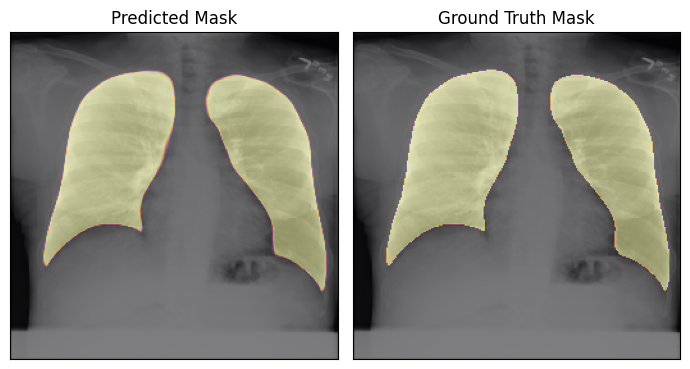

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(7, 4))
axes[0].set_title('Predicted Mask')
axes[0].imshow(test_image, cmap='gray')
axes[0].imshow(pred_mask, cmap = 'inferno', alpha = 0.5)
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title('Ground Truth Mask')
axes[1].imshow(test_image, cmap='gray')
axes[1].imshow(test_mask, cmap = 'inferno', alpha = 0.5)
axes[1].set_xticks([])
axes[1].set_yticks([])

plt.tight_layout()

### DeConvNet

Model Definition

In [ ]:
def pool_conv_block(x, filters):
  '''
  DeConvNet helper function: Performs a single convolutional layer
  + batch normalisation operation + max pooling on inputs, with n filters.

  Parameters:
      x (tensor): Input data.
      filters (int): Number of filters/convolutions to be applied.
  Returns:
      x (tensor): Output feature map after pooling
  '''
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Max pooling
  x = MaxPool2D(2)(x)
  # Regularisation
  x = Dropout(0.3)(x)
  # Return activations
  return x

def depool_conv_block(x, filters):
  '''
  DeConvNet helper function: Unpools and performs convolution +
  batch normalisation

  Parameters:
      x (tensor): Input data.
      filters (int): Number of filters/convolutions to be applied.
  Returns:
      x (tensor): Output feature map after depooling
  '''
  # Depool
  x = Conv2DTranspose(filters, 3, 2, padding="same")(x)
  # Conv2D layer
  x = Conv2D(filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Batch normalisation
  x = BatchNormalization()(x)
  # Regularisation
  x = Dropout(0.3)(x)
  # Return activations
  return x

def DeConvNet(image_size):
  '''
  DeConvNet definition, as outlined in report.

  Parameters:
    image_size (int): Size of input image.
  Returns:
    deConvNet_model (tf.keras.Model): Built Tensorflow Keras model.

  '''
  ## Read input
  inputs = Input(shape=(image_size,image_size,3))
  ## Pooling - Based on VGG16
  # Pooling, conv blocks
  x = pool_conv_block(inputs, 64)
  x = pool_conv_block(x, 128)
  x = pool_conv_block(x, 256)
  x = pool_conv_block(x, 512)
  x = pool_conv_block(x, 512)
  # Intermediate "dense layers"
  x = Conv2D(512, 1, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  x = Conv2D(512, 1, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
  # Depool, conv blocks
  x = depool_conv_block(x, 512)
  x = depool_conv_block(x, 512)
  x = depool_conv_block(x, 256)
  x = depool_conv_block(x, 128)
  x = depool_conv_block(x, 64)
  ## Output block
  outputs = Conv2D(1, 3, padding="same", activation = "sigmoid")(x)
  ## Build model
  deConvNet_model = tf.keras.Model(inputs, outputs, name = 'DeConvNet')
  # Return model
  return deConvNet_model

Initialise Hyperparameters

In [12]:
epochs = 25
learning_rate = 0.0005

Initialise Model

In [ ]:
deConvNet_model = DeConvNet(256)
deConvNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss="binary_crossentropy",
                      metrics=[dice_coefficients, "binary_accuracy"]
)

Initialise Callbacks

In [ ]:
# Model checkpoint, to save best model
deConvNet_check_point = ModelCheckpoint(filepath=PATH_TO_PROJECT+'Notebooks/model_weights/DeConvNet_weights.h5',
                              monitor='val_dice_coefficients',
                              mode = 'max',
                              save_best_only=True,
                              verbose=1
)
deConvNet_early_stop = EarlyStopping(monitor = 'val_dice_coefficients',
                           mode = 'max',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1
)
deConvNet_lr_plateau = ReduceLROnPlateau(monitor='val_dice_coefficients',
                              mode = 'max',
                              factor=0.1,
                              patience=3,
                              verbose=1
)

Training

In [ ]:
# Record start time
start_time = datetime.now()
# Begin training
deConvNet_history = deConvNet_model.fit(train_generator,
                                    steps_per_epoch=ceil(X_train.shape[0]/batch_size),
                                    validation_data=val_generator,
                                    validation_steps=ceil(X_val.shape[0]/batch_size),
                                    epochs=epochs,
                                    callbacks=[deConvNet_check_point, deConvNet_early_stop, deConvNet_lr_plateau],
                                    verbose=1
)
# Calculate run duration
duration = datetime.now() - start_time
# Print run duration
print(f'Training completed in time: {duration}')

Epoch 1/25
100/100 [==============================] - ETA: 0s - loss: 0.2561 - dice_coefficients: 0.7332 - binary_accuracy: 0.8897 
Epoch 1: val_dice_coefficients improved from -inf to 0.66704, saving model to gdrive/Shareddrives/Segmentation Project/Notebooks/model_weights/DeConvNet_weights.h5
100/100 [==============================] - 3715s 37s/step - loss: 0.2561 - dice_coefficients: 0.7332 - binary_accuracy: 0.8897 - val_loss: 3.9515 - val_dice_coefficients: 0.6670 - val_binary_accuracy: 0.8280 - lr: 5.0000e-04
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.0978 - dice_coefficients: 0.8812 - binary_accuracy: 0.9603
Epoch 2: val_dice_coefficients did not improve from 0.66704
100/100 [==============================] - 140s 1s/step - loss: 0.0978 - dice_coefficients: 0.8812 - binary_accuracy: 0.9603 - val_loss: 1.1066 - val_dice_coefficients: 0.6289 - val_binary_accuracy: 0.7630 - lr: 5.0000e-04
Epoch 3/25
100/100 [==============================] - ETA: 0s - l

### Evaluation

Use Dice Coefficients and Binary accuracy to evaluate segmentation predictions of the trained models. Evaluations are performed on the training, validation, and testing dataset, and presented in tabular.

#### Model ResUNet

In [13]:
model_filepath = PATH_TO_PROJECT+'Notebooks/model_weights/ResUNet_weights.h5'
loaded_model = models.load_model(model_filepath,custom_objects={'dice_coefficients':dice_coefficients},compile=False)

In [ ]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss="binary_crossentropy",
                      metrics=[dice_coefficients, "binary_accuracy"])

In [ ]:
resunet_test_scores = loaded_model.evaluate(test_generator, verbose= 1, steps = X_test.shape[0]/batch_size)

59/59 [==============================] - 3598s 61s/step - loss: 0.0168 - dice_coefficients: 0.9836 - binary_accuracy: 0.9939


In [ ]:
resunet_val_scores = loaded_model.evaluate(val_generator, verbose= 1, steps = X_val.shape[0]/batch_size)

39/39 [==============================] - 1930s 50s/step - loss: 0.0193 - dice_coefficients: 0.9822 - binary_accuracy: 0.9932


In [ ]:
resunet_train_scores = loaded_model.evaluate(train_generator, verbose= 1, steps = X_train.shape[0]/batch_size)

99/99 [==============================] - 6054s 61s/step - loss: 0.0100 - dice_coefficients: 0.9868 - binary_accuracy: 0.9957


Visualize the results in tabular format

In [ ]:
resunet_df = pd.DataFrame(list(zip(resunet_train_scores, resunet_val_scores, resunet_test_scores)),
               columns =['Training', 'Validation', 'Testing'],
               index = ['Loss', 'Dice Coefficient', 'Binary Accuracy'])
resunet_df

,Training,Validation,Testing
Loss,0.010203,0.010731,0.021705
Dice Coefficient,0.987742,0.986181,0.981624
Binary Accuracy,0.995669,0.995323,0.993070


In [ ]:
from tabulate import tabulate
print(tabulate(resunet_df, headers='keys', tablefmt='psql'))

+------------------+------------+--------------+-----------+
|                  |   Training |   Validation |   Testing |
|------------------+------------+--------------+-----------|
| Loss             |  0.0102031 |    0.0107315 | 0.0217052 |
| Dice Coefficient |  0.987742  |    0.986181  | 0.981624  |
| Binary Accuracy  |  0.995669  |    0.995323  | 0.99307   |
+------------------+------------+--------------+-----------+


#### Model DeConvNet

In [14]:
model_filepath = PATH_TO_PROJECT+'Notebooks/model_weights/DeConvNet_weights.h5'
loaded_model = models.load_model(model_filepath,custom_objects={'dice_coefficients':dice_coefficients},compile=False)

In [15]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss="binary_crossentropy",
                      metrics=[dice_coefficients, "binary_accuracy"])

In [ ]:
deconvnet_train_scores = loaded_model.evaluate(train_generator, verbose= 1, steps = X_train.shape[0]/batch_size)
deconvnet_val_scores = loaded_model.evaluate(val_generator, verbose= 1, steps = X_val.shape[0]/batch_size)
deconvnet_test_scores = loaded_model.evaluate(test_generator, verbose= 1, steps = X_test.shape[0]/batch_size)

47/59 [======================>.......] - ETA: 12:59 - loss: 0.0319 - dice_coefficients: 0.9674 - binary_accuracy: 0.9877

In [16]:
deconvnet_test_scores = loaded_model.evaluate(test_generator, verbose= 1, steps = X_test.shape[0]/batch_size)

59/59 [==============================] - 3717s 63s/step - loss: 0.0317 - dice_coefficients: 0.9675 - binary_accuracy: 0.9878


Visualize the results in tabular format

In [ ]:
deconvnet_df = pd.DataFrame(list(zip(deconvnet_train_scores, deconvnet_val_scores, deconvnet_test_scores)),
               columns =['Training', 'Validation', 'Testing'],
               index = ['Loss', 'Dice Coefficient', 'Binary Accuracy'])
deconvnet_df

,Training,Validation,Testing
Loss,0.020859,0.030464,0.030936
Dice Coefficient,0.973890,0.966731,0.970677
Binary Accuracy,0.990932,0.987811,0.987937


In [ ]:
from tabulate import tabulate
print(tabulate(deconvnet_df, headers='keys', tablefmt='psql'))

+------------------+------------+--------------+-----------+
|                  |   Training |   Validation |   Testing |
|------------------+------------+--------------+-----------|
| Loss             |  0.0208586 |    0.0304644 | 0.0309356 |
| Dice Coefficient |  0.97389   |    0.966731  | 0.970677  |
| Binary Accuracy  |  0.990932  |    0.987811  | 0.987937  |
+------------------+------------+--------------+-----------+


#### Comparision of Models
Compare segmentation results of the two models using the Dice Coefficients and binary accuracy with the help of a table.

In [ ]:
dice_scores_deconvnet = deconvnet_df.iloc[1]
dice_scores_resunet = resunet_df.iloc[1]
dice_df = pd.DataFrame(list(zip(dice_scores_resunet, dice_scores_deconvnet))).T
dice_df.columns=["Training","Validation","Testing"]
dice_df.index=["ResUnet","DeConvNet"]
dice_df

,Training,Validation,Testing
ResUnet,0.987742,0.986181,0.981624
DeConvNet,0.973890,0.966731,0.970677


In [ ]:
acc_scores_deconvnet = deconvnet_df.iloc[2]
acc_scores_resunet = resunet_df.iloc[2]
acc_df = pd.DataFrame(list(zip(acc_scores_resunet, acc_scores_deconvnet))).T
acc_df.columns=["Training","Validation","Testing"]
acc_df.index=["ResUnet","DeConvNet"]
acc_df

,Training,Validation,Testing
ResUnet,0.995669,0.995323,0.993070
DeConvNet,0.990932,0.987811,0.987937


Insert this snippet into browser developer tools console to ensure that colab runtime does not disconnect.

`Note: This does not go against the ToS of Google Colab`

```python
function ClickConnect(){
console.log("Working");
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click()
}
setInterval(ClickConnect,60000)
```